In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.metrics import r2_score

In [7]:
path = "/home/raim/Downloads/mTRAQ_WC_THP1_mac_library_04202023.tsv"
df = pd.read_csv(path, delimiter='\t')
original_df = pd.DataFrame(df)
distinct_df = original_df.drop_duplicates(subset='transition_group_id')

In [8]:
peptide_sequence = "ACDEFGHIKLMNPQRSTVWYacdefghiklmnpqrstvwy"   # define peptide sequence as a string 
max_sequence_length = 30    # set the maximum sequence length
num_amino_acids = 20      # number of possible amino acids

# create a dictionary to map amino acids to their indices
amino_acid_to_index = {aa: i for i, aa in enumerate(peptide_sequence)}

def one_hot_encode_sequence(sequence):
    one_hot_sequence = np.zeros((max_sequence_length, num_amino_acids), dtype=np.float32)
    for i, aa in enumerate(sequence[:max_sequence_length]):
        aa_index = amino_acid_to_index.get(aa.upper(), None)
        if aa_index is not None:
            one_hot_sequence[i, aa_index] = 1.0
    return one_hot_sequence

X_peptide = [one_hot_encode_sequence(seq) for seq in distinct_df['PeptideSequence']]

# One-hot encode charge states (assumes a maximum charge state of 5)
max_charge_state = 5
X_charge = np.zeros((len(distinct_df), max_charge_state), dtype=np.float32)

for i, charge in enumerate(distinct_df['PrecursorCharge']):
    if 1 <= charge <= max_charge_state:
        X_charge[i, charge - 1] = 1.0

# concatenate peptide sequences and charge states to create the final input (X)
X = [np.concatenate((X_peptide[i], np.tile(X_charge[i], (max_sequence_length, 1))), axis=1) for i in range(len(X_peptide))]
Y = distinct_df['IonMobility'].values
weights = distinct_df['Ms1ProfileCorr'].values

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test, weights_train, weights_test = train_test_split(X, Y, weights, test_size=0.1, random_state=42)

In [9]:
def weighted_mean_absolute_error(y_true, y_pred, weights):
    """
    Weighted Mean Absolute Error custom loss function.

    :param y_true: True labels
    :param y_pred: Predicted labels
    :param weights: Weights for each sample (based on Ms1ProfileCorr)
    :return: Weighted MAE
    """
    # Calculate the absolute error
    error = tf.abs(y_pred - y_true)
    transformed_weights = weights+0.1

    # Apply weights
    weighted_error = error * transformed_weights
    
    # Return the mean of the weighted error
    return tf.reduce_mean(weighted_error)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(max_sequence_length, num_amino_acids + max_charge_state)),
    tf.keras.layers.Dense(300, activation='swish'),
    tf.keras.layers.Dense(220, activation='swish'),
    tf.keras.layers.Dense(160, activation='swish'),
    tf.keras.layers.Dense(100, activation='swish'),
    tf.keras.layers.Dense(50, activation='swish'),
    tf.keras.layers.Dense(10, activation='swish'),
    tf.keras.layers.Dense(1, activation='linear') 
])

# compile
model.compile(optimizer='adam', loss=lambda y_true, y_pred: weighted_mean_absolute_error(y_true, y_pred, weights))
#model.compile(optimizer='adam', loss='mse')  # Customize loss function for your task

# train
model.fit(np.array(X_train), Y_train, epochs=10, batch_size=32, validation_split=0.1)

# predict
Y_pred = model.predict(np.array(X_test))
Y_pred = Y_pred.flatten()

# evaluate the model
mse = np.mean((Y_pred - Y_test) ** 2)
print("Mean Squared Error:", mse)

mae = np.mean(np.abs(Y_pred - Y_test))
print("Mean Absolute Error:", mae)

med_ae = np.median(np.abs(Y_pred - Y_test))
print("Median Absolute Error:", med_ae)

coefficient_of_dermination = r2_score(Y_test, Y_pred)
print("R-squared: ",coefficient_of_dermination)

model.save(f'IM_model')

/home/raim/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2863/2863 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 0.0187 - val_loss: 0.0105
Epoch 2/10
2863/2863 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.0103 - val_loss: 0.0096
Epoch 3/10
2863/2863 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 4/10
2863/2863 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 0.0095 - val_loss: 0.0100
Epoch 5/10
2863/2863 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 6/10
2863/2863 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/10
2863/2863 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 8/10
2863/2863 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 0.0087 - val_loss: 0.0092
Epoch 9/10
2863/2863 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 0.0086 - val_loss: 0.0090
Epoch 10/10
2863/2863 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - loss: 0.0085 - val_loss: 0.0091
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean Squared Error: 0.0007354269829465919
Mean Absolute Er

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=IM_model.

In [14]:
model.export(f'IM_model')


INFO:tensorflow:Assets written to: IM_model/assets


INFO:tensorflow:Assets written to: IM_model/assets


Saved artifact at 'IM_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 25), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  127775410487712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775410497568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775410496336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775410494400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775410499504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775410495808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775410501440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775410494048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775410503376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775410502672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127775418910320: TensorSpec

In [16]:
Y_pred

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [19]:
Y_pred[2]

0.7133206

In [20]:
from matplotlib import pyplot as plt 


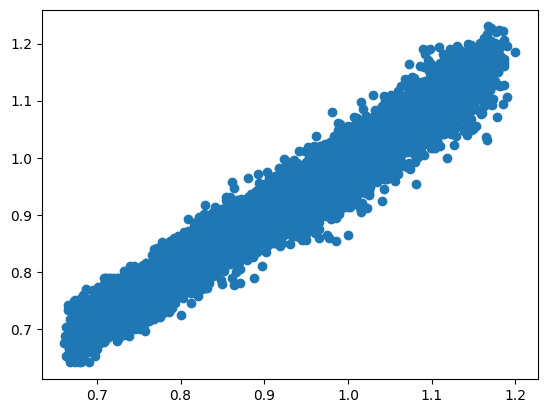

In [22]:
# Function to plot 
plt.scatter(Y_pred, Y_test) 
 
# function to show the plot 
plt.show()